
# Tutorial: Traj Preprocessing

**The following notebook illustrate the `TrajPreprocessing` class how to run the preprocessing steps.**
- **Several preprocessing steps are available for the tail angle**:
  - Interpolating missing values
  - Apply 1€ filter

- **The kinematic vigor is also computed from the speed and will also be useful for segmentation into bouts**:



* Loading dependencies

In [2]:
sphinx_gallery_thumbnail_path = 'logo_color_dark.png'

In [1]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.load_example import load_example_data
from megabouts.tracking_data.tracking_data import FullTrackingData

from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingConfig
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingResult
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessing

ModuleNotFoundError: No module named 'megabouts.utils.utils_dataframe'

## Loading Data

* TrackingConfig and TrackingData similar to [tutorial_Loading_Data](./tutorial_Loading_Data.ipynb)

In [2]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

In [3]:
from megabouts.utils.utils_downsampling import create_downsampling_function


In [4]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')


head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

fps = 60
downsampling_f, _, _, _ = create_downsampling_function(fps, 700, len(head_x) * 1000 / 700)
head_x = downsampling_f(head_x, axis=0)
head_y = downsampling_f(head_y, axis=0)
head_yaw = downsampling_f(head_yaw, axis=0)
tail_angle = downsampling_f(tail_angle, axis=0)

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

## Run Preprocessing

* Define preprocessing config

In [5]:
traj_preprocessing_cfg = TrajPreprocessingConfig(fps=tracking_cfg.fps)

In [6]:
traj_df_input = tracking_data.traj_df

traj = TrajPreprocessing(traj_preprocessing_cfg).preprocess_traj_df(traj_df_input)

In [7]:
traj.df.head(5)

,x,y,yaw,x_smooth,y_smooth,yaw_smooth,axial_speed,lateral_speed,yaw_speed,vigor,no_tracking
0,-22.979468,3.989994,-2.218813,-22.979468,3.989994,-2.218813,NaN,NaN,NaN,0.0,0.0
1,-22.990228,3.989290,-2.228331,-22.986751,3.989518,-2.225255,NaN,NaN,NaN,0.0,0.0
2,-22.969361,3.994143,-2.216719,-22.974899,3.992649,-2.219442,-0.146637,0.060273,-0.018851,0.0,0.0
3,-22.999877,3.953214,-2.221179,-22.991995,3.965878,-2.220624,0.660204,0.303063,0.138920,0.0,0.0
4,-23.005045,3.927213,-2.209680,-23.000969,3.939064,-2.213209,1.753138,0.349947,0.186993,0.0,0.0


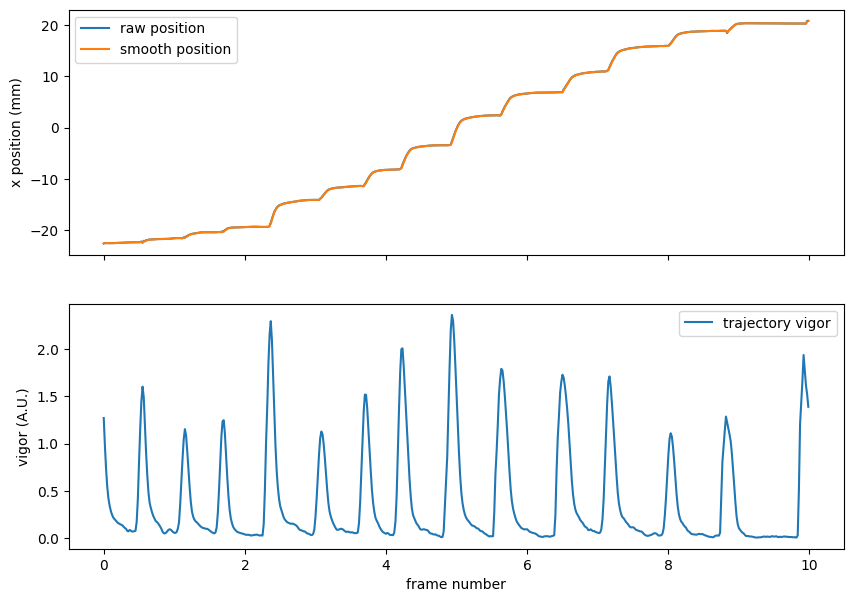

In [8]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps

t_win = t[IdSt:IdSt+Duration]-t[IdSt]
fig,ax = plt.subplots(2,1,figsize=(10,7),sharex=True)
ax[0].plot(t_win,traj.x[IdSt:IdSt+Duration],label='raw position')
ax[0].plot(t_win,traj.x_smooth[IdSt:IdSt+Duration],label='smooth position')
ax[1].plot(t_win,traj.vigor[IdSt:IdSt+Duration],label='trajectory vigor')
ax[0].set(ylabel='x position (mm)')
ax[1].set(ylabel='vigor (A.U.)')
ax[1].set(xlabel='frame number')

for i in range(2):
    ax[i].legend()
plt.show()

# Tuning [1€ filter](https://gery.casiez.net/1euro/)

> &#x1F4DD;	
> There are two configurable parameters in the filter, the minimum cutoff frequency `freq_cutoff_min` and the speed coefficient `beta`.\
> Decreasing the minimum cutoff frequency decreases slow speed jitter. Increasing the speed coefficient decreases speed lag.\
> The parameters are set using two-step procedure:

### **Step 1**

**`beta` is set to 0 and `freq_cutoff_min` to 10Hz. Focus on a part of the recording where the fish is not swimming or swimming at low speed.\
 `freq_cutoff_min` is adjusted to remove jitter and preserve an acceptable lag during these slow movements.**

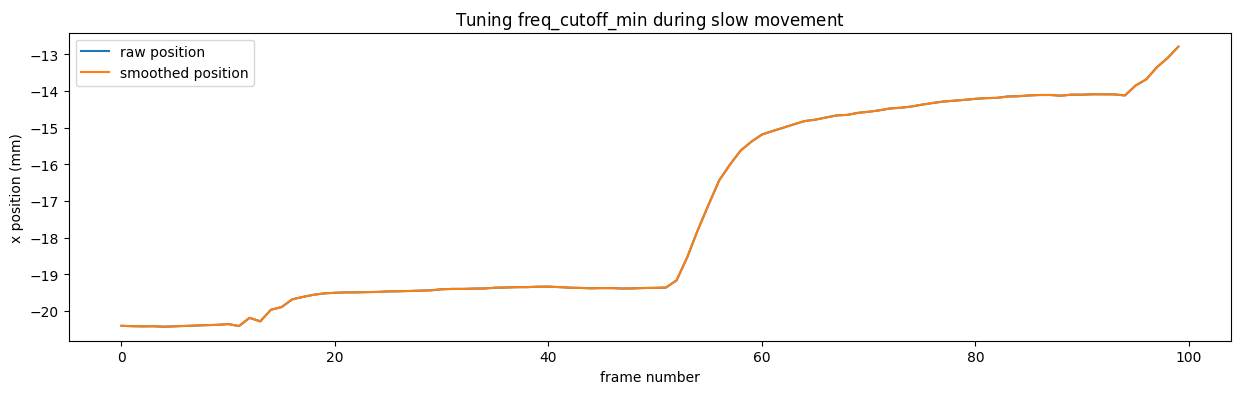

In [14]:
IdSt = 100
Duration = 100

x = traj.x
x_smooth = TrajPreprocessing.one_euro_filter(x,freq_cutoff_min=10000,beta = 0, rate = tracking_cfg.fps)

fig,ax = plt.subplots(1,1,figsize=(15,4),sharex=True)
ax.set_title('Tuning '+ r'$\text{freq_cutoff_min}$'+ ' during slow movement')
ax.plot(x[IdSt:IdSt+Duration],label='raw position')
ax.plot(x_smooth[IdSt:IdSt+Duration],label='smoothed position')
ax.set(xlabel='frame number',ylabel='x position (mm)')
ax.legend()
plt.show()

&#x2705;	 Here a value close to 10Hz for `freq_cutoff_min` allows to smooth while keeping an acceptable lag*

### **Step 2**

**Focus on a part of the recording where the fish is moving fast. Adjust `beta` with a focus on minimizing lag.**

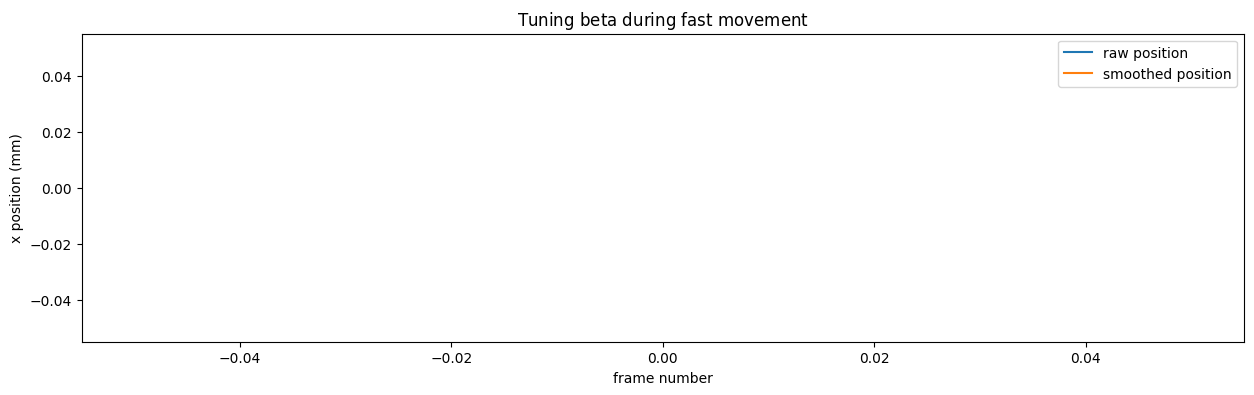

In [12]:
IdSt = 83600
Duration = 500

x = traj.x
x_smooth = TrajPreprocessing.one_euro_filter(x,freq_cutoff_min=8,beta=1.4,rate=tracking_cfg.fps)

fig,ax = plt.subplots(1,1,figsize=(15,4),sharex=True)
ax.set_title('Tuning '+ r'$\text{beta}$'+ ' during fast movement')
ax.plot(x[IdSt:IdSt+Duration],label='raw position')
ax.plot(x_smooth[IdSt:IdSt+Duration],label='smoothed position')
ax.set(xlabel='frame number',ylabel='x position (mm)')
ax.legend()
plt.show()

&#x2705;	*Here we selected `beta=1.4`*